# Group-based Regression Models

### Importing libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import math
import os
import sys

In [2]:
# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [3]:
import sklearn
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

In [4]:
from pycaret.regression import *

In [5]:
import functions as f

# Carbon-based NMs regression model

In [6]:
model_name = "carbon_based"
group_name = "carbon"
seed = 123

### Load the data and filter instances

In [7]:
data_train_df = pd.read_csv("output/datasets/universal/data_regression_train_df.csv", encoding="utf-8")
data_test_df = pd.read_csv("output/datasets/universal/data_regression_test_df.csv", encoding="utf-8")
data_df = pd.concat([data_train_df,data_test_df])

del data_train_df
del data_test_df

In [8]:
data_df.shape

(11315, 20)

In [9]:
data_group_df = data_df[data_df['nanomaterial_group'] == group_name]

In [10]:
data_group_df.shape

(212, 20)

In [11]:
data_group_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,nanomaterial_group,Viability
82,C60,Dextran,30.29,372.0,-10.1,NaN,Sphere,10.00,24.0,C6,Rat,Brain,Fibroblast,Adult,cancer,NaN,NR,toluylene red,carbon,81.35
177,Carbon,None,21.00,NaN,NaN,NaN,Sphere,25.00,24.0,Macrophages,Mouse,Peritoneal Cavity,Macrophage,Adult,Normal,NaN,WST-1,TetrazoliumSalt,carbon,95.88
301,Carbon,None,22.61,NaN,NaN,NaN,NaN,0.02,24.0,IP15,Human,Kidney,Spindle,Adult,Normal,male,WST-1,TetrazoliumSalt,carbon,47.09
311,Carbon,None,165.15,NaN,NaN,NaN,NaN,0.00,24.0,IP15,Human,Kidney,Spindle,Adult,Normal,male,WST-1,TetrazoliumSalt,carbon,100.00
372,Carbon,None,22.61,NaN,NaN,NaN,NaN,0.00,24.0,IP15,Human,Kidney,Spindle,Adult,Normal,male,WST-1,TetrazoliumSalt,carbon,90.58


### Create training set and test set

In [12]:
data_group_df = f.quantile_discretize(data_group_df, 'Viability')

In [13]:
splitter = setup(data = data_group_df, target = 'Viability_discrete',
                 preprocess = False,
                 train_size=0.8,
                 data_split_stratify=True,
                 # don't change the following
                 session_id = seed,
                 use_gpu=False,
                 log_experiment = False,
                 silent=True,
                 experiment_name = 'splitter')

,Description,Value
0,session_id,123
1,Target,Viability_discrete
2,Original Data,"(212, 21)"
3,Missing Values,True
4,Numeric Features,6
5,Categorical Features,14
6,Transformed Train Set,"(169, 19)"
7,Transformed Test Set,"(43, 19)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,True


In [14]:
data_group_train_df = get_config(variable="X_train").copy()
#data_group_train_df['Viability'] = get_config(variable="y_train").copy()

data_group_test_df = get_config(variable="X_test").copy()
#data_group_test_df['Viability'] = get_config(variable="y_test").copy()

In [15]:
print(data_group_train_df.shape)
print(data_group_test_df.shape)

(169, 19)
(43, 19)


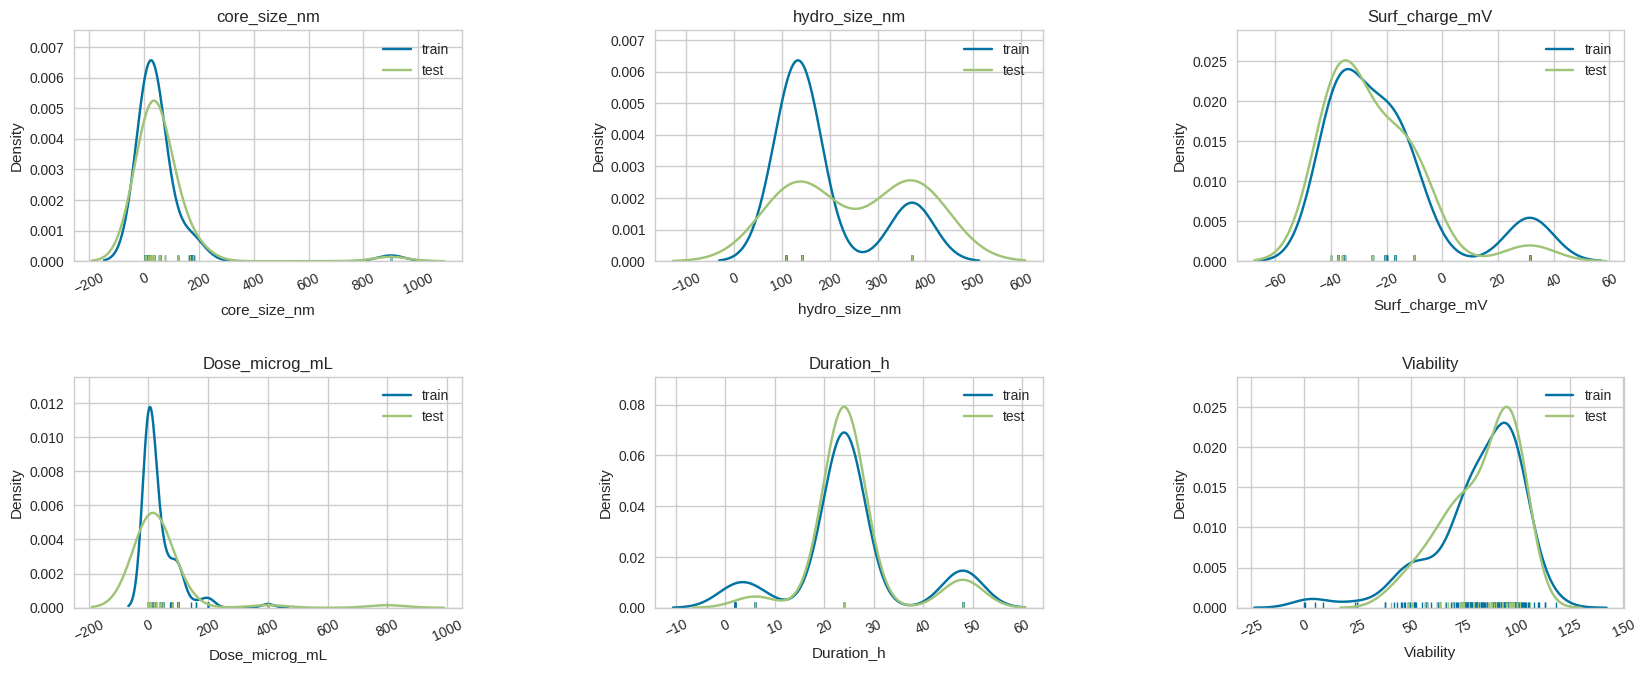

In [16]:
f.plot_distribution_train_test(data_group_train_df, data_group_test_df)

### Save cleaned datasets

In [21]:
data_group_train_df.to_csv('output/datasets/'+model_name+'/data_regression_'+model_name+'_train_df.csv', encoding='utf-8', index=False)

In [22]:
data_group_test_df.to_csv('output/datasets/'+model_name+'/data_regression_'+model_name+'_test_df.csv', encoding='utf-8', index=False)

### Use the best scenario identified in step 01

In [25]:
sc_ignore_features = ['nanomaterial_group', 'Coating', 'Cell_name']
sc_bin_numeric_features = None
sc_high_cardinality_features = None

sc_imputation_type = 'iterative'
sc_numeric_imputation = 'mean'

sc_normalize = True
sc_remove_outliers = True

### Data Preprcoessing

In [26]:
stup = setup(data = data_group_train_df, target = 'Viability', 
              
        test_data = data_group_test_df,

        imputation_type = sc_imputation_type, 
        numeric_imputation = sc_numeric_imputation, #default: mean

        categorical_imputation = "constant", #default: constant
        iterative_imputation_iters = 5, #default: 5
        numeric_iterative_imputer = "lightgbm",
        categorical_iterative_imputer = "lightgbm",

        ignore_features = sc_ignore_features,
        bin_numeric_features = sc_bin_numeric_features,
        high_cardinality_features = sc_high_cardinality_features,

        high_cardinality_method = "frequency", #default: frequency
        handle_unknown_categorical = True, #default
        unknown_categorical_method = "least_frequent", #default

        normalize = sc_normalize, #default: False
        remove_outliers= sc_remove_outliers, #default: False

        outliers_threshold = 0.05, #default

        transformation= False, #default
        transformation_method = 'yeo-johnson', #default
        transform_target = False, 
        combine_rare_levels = False,
        rare_level_threshold = 0.1, #default: 0.1

        remove_multicollinearity = False, #default 
        multicollinearity_threshold = 0.9, #default

        ignore_low_variance = True, 

        feature_interaction = False, 
        feature_ratio = False,
        polynomial_features = False, 
        trigonometry_features = False,

        # don't change the following
        session_id = seed,
        use_gpu=False,
        log_experiment = False,
        silent=True,
        experiment_name = model_name)

set_config('seed', seed)

,Description,Value
0,session_id,123
1,Target,Viability
2,Original Data,"(169, 19)"
3,Missing Values,True
4,Numeric Features,5
5,Categorical Features,10
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(160, 37)"


In [27]:
print(get_config(variable="X_train").shape)
print(get_config(variable="y_train").shape)

(160, 37)
(160,)


In [28]:
print(get_config(variable="X").shape)
print(get_config(variable="y").shape)

(169, 37)
(169,)


In [29]:
set_config('X_train', get_config(variable="X").copy()) 
set_config('y_train', get_config(variable="y").copy()) 

In [30]:
print(get_config(variable="X_train").shape)
print(get_config(variable="y_train").shape)

(169, 37)
(169,)


In [31]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(43, 37)
(43,)


In [32]:
#load_config('output/models/universal_regression_rf.cfg')

In [33]:
data_group_train_transformed_df = get_config(variable="X").copy()
data_group_train_transformed_df['Viability'] = get_config(variable="y").copy()

In [34]:
data_group_test_transformed_df = get_config(variable="X_test").copy()
data_group_test_transformed_df['Viability'] = get_config(variable="y_test").copy()

In [35]:
data_group_train_transformed_df.to_csv('output/datasets/'+model_name+'/transformed/data_regression_'+model_name+'_train_transformed_df.csv', encoding='utf-8', index=False)
data_group_test_transformed_df.to_csv('output/datasets/'+model_name+'/transformed/data_regression_'+model_name+'_test_transformed_df.csv', encoding='utf-8', index=False)

### Model Comparison

In [36]:
top_model = compare_models(exclude=['lar','llar'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,6.9829,147.1159,11.2423,0.6870,0.3639,36.7375,0.0640
xgboost,Extreme Gradient Boosting,7.2013,150.5858,11.4824,0.6783,0.3719,36.7433,0.0680
gbr,Gradient Boosting Regressor,7.8523,163.4046,12.0293,0.6521,0.3795,37.4126,0.0120
rf,Random Forest Regressor,7.9278,171.8102,12.4390,0.6331,0.3865,37.1680,0.0770
catboost,CatBoost Regressor,7.9643,175.8861,12.5799,0.6187,0.3900,36.7653,1.5290
dt,Decision Tree Regressor,8.1903,179.3650,12.6470,0.5988,0.3794,36.7503,0.0050
lightgbm,Light Gradient Boosting Machine,10.8623,246.2655,15.2451,0.4607,0.4191,38.5147,0.0110
ridge,Ridge Regression,10.9113,267.8172,15.8549,0.4220,0.4269,37.6465,0.0040
lr,Linear Regression,11.0431,274.5960,16.0696,0.4001,0.4264,36.8108,0.4540
br,Bayesian Ridge,11.5354,285.9394,16.3793,0.3887,0.4349,39.0913,0.0050


In [37]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_regression_model_comparison_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [38]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(43, 37)
(43,)


In [39]:
print(results_df.iloc[0,0])

et


### 10-fold cross-validation of the best performing model

In [40]:
model = create_model(results_df.iloc[0,0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.7809,51.7606,7.1945,0.8320,0.1045,0.0691
1,4.8626,34.4795,5.8719,0.9248,0.1109,0.0826
2,4.5957,43.1728,6.5706,0.8720,0.0962,0.0652
3,5.5669,50.1451,7.0813,0.8074,0.0969,0.0683
4,8.5179,113.8394,10.6696,0.7439,0.1527,0.1266
5,12.7240,456.4276,21.3642,0.3073,0.9509,50.4429
6,7.4780,166.2468,12.8937,0.7635,0.4223,0.3518
7,6.2870,165.2469,12.8548,0.2738,0.1850,0.0734
8,7.0565,194.6431,13.9515,0.6800,0.9702,315.4606


In [41]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_regression_model_cross_validation_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [42]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(43, 37)
(43,)


### Finalize the model

In [43]:
final_model = finalize_model(model)

In [44]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(43, 37)
(43,)


### Test the model on the test set

In [45]:
pred_test_set = predict_model(final_model, data=data_group_test_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,7.4337,145.1435,12.0476,0.4701,0.1771,0.1074


In [46]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_regression_model_test_set_validation_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [47]:
predict_model(final_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,7.4337,145.1435,12.0476,0.4701,0.1771,0.1074


,core_size_nm,hydro_size_nm,Surf_charge_mV,Dose_microg_mL,Duration_h,NP_type_C60,NP_type_C70,NP_type_Carbon,NP_type_Diamond,NP_type_Graphite,...,Cell_age_fetus,Cell_age_neonate,cell_type_cancer,Assay_MTT,Assay_WST-1,Test_indicator_CalceinAM,Test_indicator_TetrazoliumSalt,Test_indicator_toluylene red,Viability,Label
0,-0.405206,-0.574216,0.125431,-0.579202,-0.109321,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,98.230003,96.945000
1,-0.284601,1.093279,0.415690,-0.581773,-0.109321,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,73.989998,77.702249
2,-0.418919,0.940552,3.241984,0.221506,-0.109321,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,101.269997,110.059998
3,-0.014739,-0.226504,-0.854434,-0.581934,1.943491,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,65.879997,49.505385
4,-0.060209,-0.379231,-0.977411,5.845583,-0.109321,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,56.680000,77.760002
5,-0.060209,-0.379231,-0.977411,0.221506,-0.109321,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,87.919998,81.879997
6,-0.284601,1.093279,0.415690,-0.581934,-0.109321,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,95.070000,93.945000
7,-0.229171,2.084006,0.786095,1.024945,-0.109321,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,86.919998,79.893402
8,-0.193083,-0.226504,-0.348614,-0.581934,-0.109321,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,97.309998,95.959999
9,-0.197775,-1.182074,-0.829466,-0.565865,-0.109321,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,50.779999,45.758498


### Inspect model plots

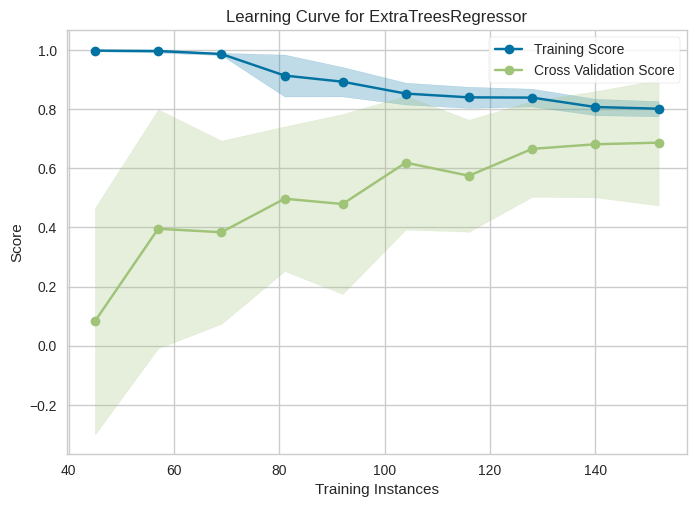

In [48]:
plot_model(final_model, plot = 'learning')

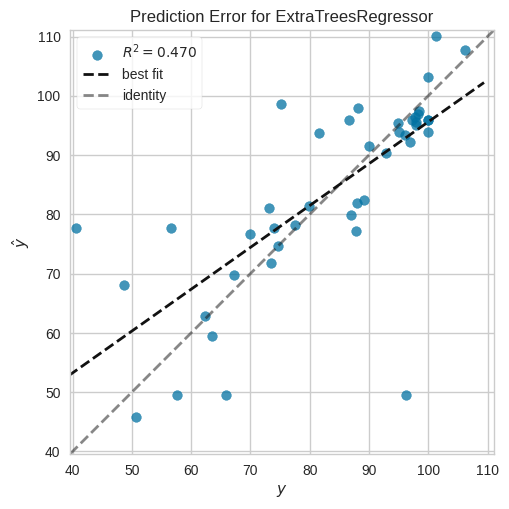

In [49]:
plot_model(final_model, plot = 'error')

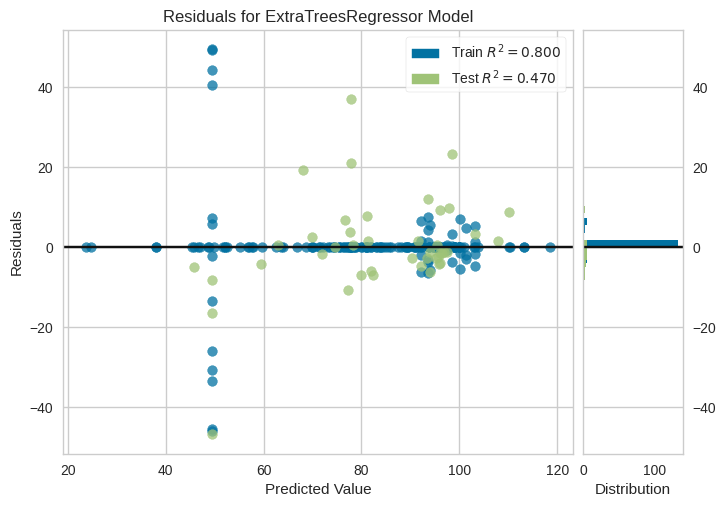

In [50]:
plot_model(final_model, plot = 'residuals')

### Feature importance plot

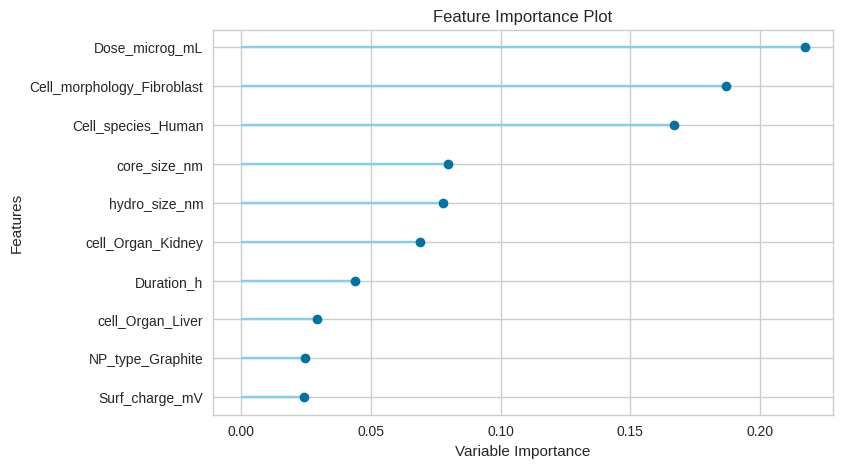

In [51]:
plot_model(final_model, plot = 'feature')

### Save the model to file

In [52]:
save_config('output/models/'+model_name+'_regression_config.cfg')

In [53]:
save_model(final_model, 'output/models/'+model_name+'_regression_model.mdl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['nanomaterial_group',
                                                        'Coating', 'Cell_name'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='Viability',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type...
                  ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                      criterion='mse', max_depth=None,
                                      max_features='auto', max_leaf_nodes=None,
                                      max_samples=None,
    